In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



In [ ]:

batch_size = 128
latent_dim = 20
num_epochs = 50
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



100%|██████████| 26.4M/26.4M [00:01<00:00, 18.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 312kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.29MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# cVAE
class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + label_dim, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + label_dim, 400)
        self.fc2 = nn.Linear(400, output_dim)

    def forward(self, z, labels):
        z = torch.cat([z, labels], dim=1)
        h = torch.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon

class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, label_dim, latent_dim)
        self.decoder = Decoder(latent_dim, label_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, labels)
        return x_recon, mu, logvar


In [ ]:

def one_hot(labels, num_classes=10):
    return torch.eye(num_classes)[labels].to(device)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD




In [ ]:
# initialization
input_dim = 28 * 28
label_dim = 10
model = CVAE(input_dim, label_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(device)
        labels = one_hot(labels, label_dim)

        # normalization
        data = (data + 1) / 2

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")




Epoch [1/50], Loss: 283.3067
Epoch [2/50], Loss: 254.2831
Epoch [3/50], Loss: 248.4308
Epoch [4/50], Loss: 245.4207
Epoch [5/50], Loss: 243.5505
Epoch [6/50], Loss: 242.2222
Epoch [7/50], Loss: 241.2739
Epoch [8/50], Loss: 240.4827
Epoch [9/50], Loss: 239.9049
Epoch [10/50], Loss: 239.3595
Epoch [11/50], Loss: 238.9789
Epoch [12/50], Loss: 238.5703
Epoch [13/50], Loss: 238.2599
Epoch [14/50], Loss: 237.9995
Epoch [15/50], Loss: 237.6745
Epoch [16/50], Loss: 237.5186
Epoch [17/50], Loss: 237.2747
Epoch [18/50], Loss: 237.0455
Epoch [19/50], Loss: 236.8783
Epoch [20/50], Loss: 236.7904
Epoch [21/50], Loss: 236.6444
Epoch [22/50], Loss: 236.4797
Epoch [23/50], Loss: 236.3930
Epoch [24/50], Loss: 236.2977
Epoch [25/50], Loss: 236.1352
Epoch [26/50], Loss: 236.0563
Epoch [27/50], Loss: 235.9553
Epoch [28/50], Loss: 235.8954
Epoch [29/50], Loss: 235.7942
Epoch [30/50], Loss: 235.7550
Epoch [31/50], Loss: 235.6565
Epoch [32/50], Loss: 235.6396
Epoch [33/50], Loss: 235.5216
Epoch [34/50], Loss

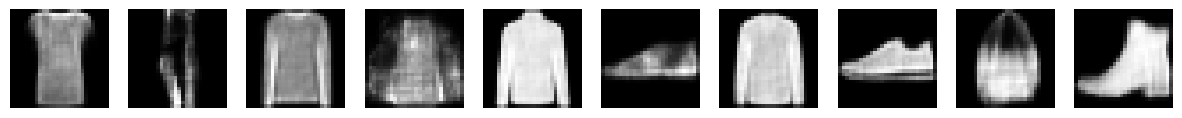

In [ ]:
# test
model.eval()
with torch.no_grad():
    labels = torch.arange(10).long()
    labels_onehot = one_hot(labels, label_dim)
    z = torch.randn(10, latent_dim).to(device)
    samples = model.decoder(z, labels_onehot).view(-1, 1, 28, 28).cpu()

    # visualization
    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axs):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

Invalid text input: 'hat'. Valid options are: ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']


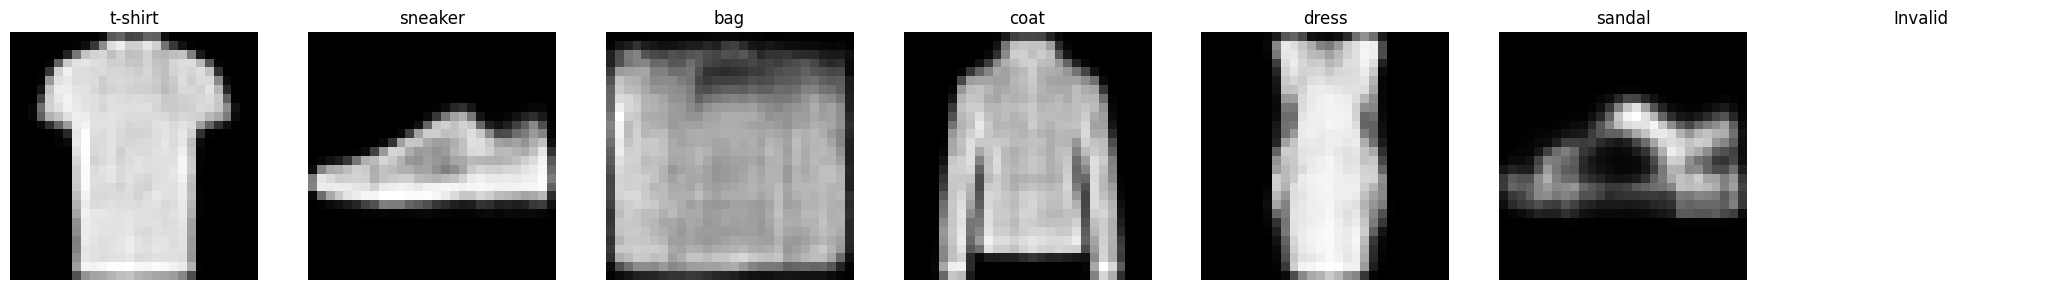

In [ ]:
def get_label_from_text(text):
    """Map text description to label number"""
    label_map = {
        't-shirt': 0,
        'trouser': 1,
        'pullover': 2,
        'dress': 3,
        'coat': 4,
        'sandal': 5,
        'shirt': 6,
        'sneaker': 7,
        'bag': 8,
        'boot': 9
    }

    label = label_map.get(text.lower())
    if label is None:
        raise ValueError(f"Invalid text input: '{text}'. Valid options are: {list(label_map.keys())}")

    label = torch.tensor(label_map.get(text.lower(), -1)).to(device)
    labels_onehot = one_hot(label, num_classes=10)
    return labels_onehot


def generate_from_texts(model, texts):
    model.eval()
    with torch.no_grad():
        num_texts = len(texts)
        fig, axs = plt.subplots(1, num_texts, figsize=(num_texts * 3, 3))
        if num_texts == 1:
            axs = [axs]

        for i, text in enumerate(texts):
            try:
                labels_onehot = get_label_from_text(text).unsqueeze(0)
                z = torch.randn(1, latent_dim).to(device)
                samples = model.decoder(z, labels_onehot).view(-1, 1, 28, 28).cpu()
                axs[i].imshow(samples.squeeze(), cmap="gray")
                axs[i].axis('off')
                axs[i].set_title(text)

            except ValueError as e:
                print(e)
                axs[i].axis('off')
                axs[i].set_title("Invalid")

        plt.tight_layout()
        plt.show()

texts = ["t-shirt", "sneaker", "bag", "coat", "dress", "sandal", "hat"]
generate_from_texts(model, texts)